## Processing Eumetnet's WOW dataset for modelling tasks

For these collaboration lines with RDWK we need to write code transforming raw WOW observations into the formats required for data assimilation (i.e. HARMONIE-AROME) and model verification (i.e. HARP). This implies carrying out some "infrastructural" tasks (e.g. reshaping raw files), but also some other tasks to ensure data quality (e.g. filtering implausible observations, passing quality controls). In this notebook we attept a step-by-step description of this data processing workflow, so that it can be shared with other crowdsourced data practitioners interested in using novel observations for modelling tasks. 

Here is the list of tasks carried out in this file:

1. **Cropping to the European extent:** the original Eumetnet's WOW actually contains GLOBAL observations. We need to crop to the European extent, so it coincides with the models.
2. **Grouping the observations on a per-hour basis:** the raw dataset is a set of 12 large CSV files (i.e. 4GB each) grouped per month. It seems more usable if these are turned into hourly files. 
3. **Filtering climatically implausible observations:** in consultation with Gerard, we establish a climatic range for each of the weather variables. Fields with implausible measurements (e.g. negative rain) will be casted to NaN.
4. **Quantities measured transformed into model standards:** make sure WOW measurements are transformed into the right units for the model (e.g. temperature in Kelvin)
                                                                    

### Import libraries and set global variables

In [8]:
import os
import pytz
import duckdb
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import shutup; shutup.please()
from shapely.geometry import box
from collections import defaultdict

import sys
sys.path.append("/home/jovyan/work/private/sources/projects/wow4mod/quality")
from wow_airtemp_napomod import *

pd.options.display.max_columns = 5000
pd.options.display.width = 0

# For now, same as the one used in the E-OBS: [25N-71.5N x 25W-45E]
xmin, xmax, ymin, ymax = [-25, 45, 25, 71.5]
european_extent = box(xmin, ymin, xmax, ymax)

meta_cols_to_keep = "Id,Site Id,Longitude,Latitude,Report Date / Time".split(',')
data_cols_to_keep = "Air Temperature,Wet Bulb,Dew Point,Mean Sea-Level Pressure,Pressure (At Station),Relative Humidity,Rainfall Rate,Rainfall Accumulation,Wind Speed,Wind Direction,Wind Gust,Wind Gust Direction".split(',')

print("Meta cols to keep: ", meta_cols_to_keep)
print("Data cols to keep: ", data_cols_to_keep)


Meta cols to keep:  ['Id', 'Site Id', 'Longitude', 'Latitude', 'Report Date / Time']
Data cols to keep:  ['Air Temperature', 'Wet Bulb', 'Dew Point', 'Mean Sea-Level Pressure', 'Pressure (At Station)', 'Relative Humidity', 'Rainfall Rate', 'Rainfall Accumulation', 'Wind Speed', 'Wind Direction', 'Wind Gust', 'Wind Gust Direction']


### Iterating over the file structure and writing clean files (`L0` product)

The big size of the monthly files implies that we need to read them in chunks using pandas `chunksize` parameter at reading time. Naturally, reading a fixed number of row might split a full hour of data across two chunks. The idea is reading 1M rows and group them by hour. Then we will write each of the groups in a CSV file, but we keep the last group to be merged with the first group of the next chunk. For simplicity, we write this basic carpentry into a new file structure labeled as `L0` (i.e. level 0). The filtering of implausible observations will be done in subsequent levels. 

In [7]:
path_in = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw"
path_ou = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/{0}"

file_ou_template = "WOW-Eumetnet-L0-{0}_{1}.csv"

for root, dirs, files in os.walk(path_in):
    for file in sorted(files):
        if file.endswith(".csv"):
            path_cur = os.path.join(path_in, file)
            print("Processing chunks from file: ", path_cur)
            last_hour_idx = None
            last_hour_data = None
            for chunk in pd.read_csv(path_cur, sep=",", parse_dates=[4], chunksize=100000):
                # Trimming the columns down
                chunk = chunk[meta_cols_to_keep + data_cols_to_keep]              
                # Making a geodataframe for the spatial filtering
                gdf_chunk = gpd.GeoDataFrame(chunk, geometry=gpd.points_from_xy(chunk.Longitude, chunk.Latitude), crs="EPSG:4326")
                # Forcing datetime field into correct format, because reasons
                gdf_chunk["Report Date / Time"] =  pd.to_datetime(gdf_chunk['Report Date / Time'], format='mixed')
                gdf_clipped = gpd.clip(gdf_chunk, mask=european_extent)

                # Grouping by hour and iterating each of the groups to write in file
                groups = list(gdf_clipped.groupby([gdf_clipped['Report Date / Time'].dt.hour]))                
                for idx, group in groups:
                    # print(idx, group.shape)
                    date_first_row = group['Report Date / Time'].iloc[0].date()
                    file_ou = file_ou_template.format(date_first_row, str(idx[0]).zfill(2))
                    path_cur_ou = path_ou.format(file_ou)

                    # We concat with previous batch, if any
                    if last_hour_idx != None:
                        group = pd.concat([last_hour_data, group ], ignore_index=True)
                        last_hour_idx = None
                        last_hour_data = None

                    # Concat or not, we write the group to file
                    group.to_csv(path_cur_ou, header=True, index=True)
                
                # Keep the index of the last group and its observations for the next iteration
                last_hour_idx, last_hour_data = [groups[-1][0], groups[-1][1]]           

Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202001_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202002_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202003_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202004_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202005_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202006_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/raw/metoffice-wow_europe_202007_v1_raw.csv
Processing chunks from file:  /home/jovyan/work/private/data-c

### Filtering climatically implausible observations (`L1` product)

Check the following links to find extremes:
- Temperature records: https://rcccm.dwd.de/DWD-RCCCM/EN/products/significant/records/records_tmax_tmin.pdf?__blob=publicationFile&v=13
- Wind records: https://nhess.copernicus.org/articles/12/1969/2012/nhess-12-1969-2012.pdf
- Rainfall records (for the Netherlands): https://www.wunderground.com/blog/weatherhistorian/national-24hour-precipitation-records.html
- Rainfall records (for Europe): https://www.accuweather.com/en/severe-weather/extreme-rainfall-in-liguria-italy-breaks-europe-record/1028429
- Air pressure: https://en.wikipedia.org/wiki/List_of_atmospheric_pressure_records_in_Europe 

**Gerard's wisdom:**

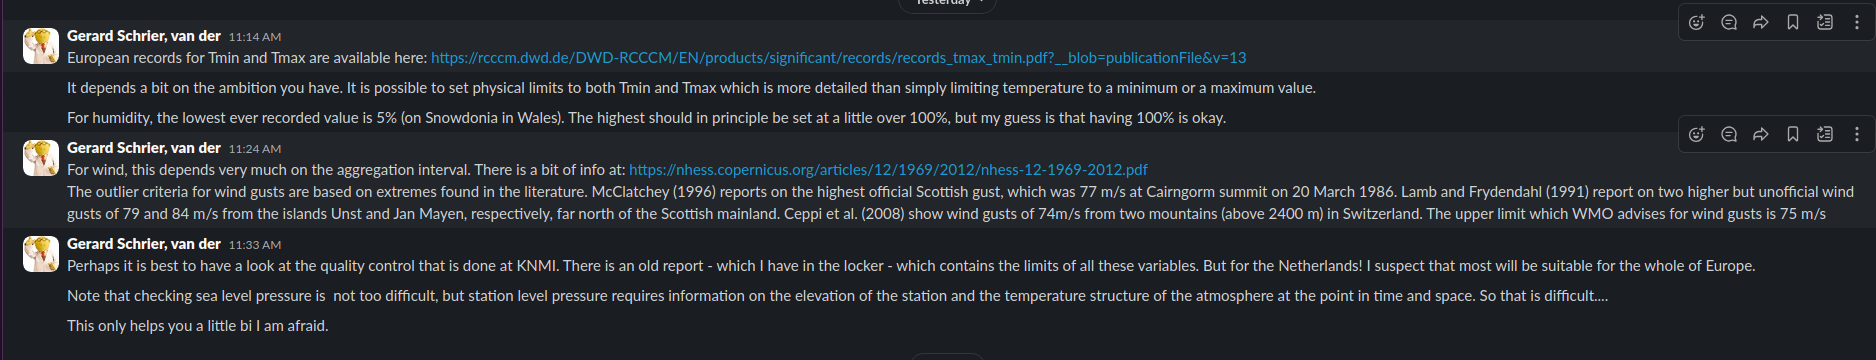


The following function uses `pandas` + `numpy` methods to examine each column containing measurements. It checks whether 
the measurements are within the established climatology records, or not. If not, the values are casted to a value of `-99`. These 
values can be refined in the near future, for now they are intended to filter the really gross errors (e.g. `wind speeds of 1000 km/h`).

In [93]:
# Check the following links to find the measured extremes: 
climatological_range = {"Air Temperature":[-52.6, 49.5], "Wet Bulb":[-52.6, 49.5], "Dew Point":[-52.6, 49.5], 
                       "Mean Sea-Level Pressure":[920, 1069], "Pressure (At Station)":[920, 1069], "Relative Humidity":[5, 100], 
                       "Rainfall Rate":[0, 75], "Rainfall Accumulation":[0, 883], 
                       "Wind Speed":[0, 75], "Wind Direction":[0, 360], "Wind Gust":[0, 75], "Wind Gust Direction":[0, 360]}

def is_in_range(col, min_clim, max_clim):
    try:
        col = np.where((col < min_clim) | (col > max_clim), -99, col)    
    except TypeError:
        # Empty cells might be casted as type 'str'. At least happens
        # for the `Wind Speed` column of the 2nd file of the year. It
        # seems they can also be casted to np.nan and does not cause
        # problems. Just writing it here for the record.
        col = -99
    return col    

def filter_by_climatological_range(df):
    # This function will cast to -99 cells outside the climatological range for 
    # a particular weather variable
    for column in df.columns.tolist()[1:-1]:
        if column in climatological_range.keys():
            # print("This column: ", column)
            min_clim, max_clim = climatological_range[column]
            df[column] = df[column].apply(is_in_range, args=(min_clim, max_clim))            
    return df

Once the function is defined, we iterate through the `L0` file structure, filtering the implausible values, and then we writing the `L1` files that can feed the quality controls

In [97]:
path_in = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/{0}"
path_ou = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L1/{0}"

file_in_template = "WOW-Eumetnet-L0-{0}_{1}.csv"
file_ou_template = "WOW-Eumetnet-L1-{0}_{1}.csv"

sd = datetime.datetime(2020, 7, 1)
ed = datetime.datetime(2021, 1, 1)

date_range = pd.date_range(start=sd, end=ed, freq="H")[:-1]

for date in date_range:
    file_in = file_in_template.format(date.date(), str(date.time().hour).zfill(2))
    file_ou = file_ou_template.format(date.date(), str(date.time().hour).zfill(2))
    path_cur_in = path_in.format(file_in)
    path_cur_ou = path_ou.format(file_ou)

    if date.day == 1:
        print("Processing: ", path_cur_in)

    try:

        df = pd.read_csv(path_cur_in, sep=",", parse_dates=[5])
        df = filter_by_climatological_range(df)
        df.to_csv(path_cur_ou, header=True, index=True)

    except FileNotFoundError:
        print("Date not found: ", date)

Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_00.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_01.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_02.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_03.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_04.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_05.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_06.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L0/WOW-Eumetnet-L0-2020-07-01_07.csv
Processing:  /home/jovyan/work/private/data-common/KNMI/eumetnet-wow-202

Output cell above is collapsed to avoid visual cluttering!

### Applying the quality control for WOW's air temperature observations (`L2` product)

<div class="alert alert-block alert-warning">
<b>Note:</b> The quality control uses pre-existing auxiliary files that were computed in 2022 in the context of Eumetnet`s Study A1.05. 
Check <a href="https://www.eumetnet.eu/wp-content/uploads/2023/06/Crowdsourcing-PWS-Quality-Control-A1.05_KNMI_Final_2022.pdf">this link</a> for more information.
</div>

<div class="alert alert-block alert-success">
<b>Note:</b> Having reached this point, we are ready to apply the available quality control for air temperature observations. 
Check <a href="https://www.eumetnet.eu/wp-content/uploads/2023/06/Crowdsourcing-PWS-Quality-Control-A1.05_KNMI_Final_2022.pdf">this link</a> for more information.
</div>


#### Initializing parameters and loading pre-computed information

In [5]:
# The following files were computed in 2022 in the context of a Eumetnet project
# This means that they are available for the study year (2020), but not for any
# other years. Computing them required inserting all the observations in a Postgres
# database and then querying the db making some count operations

path_common = r"../reference_tables/{0}"

path_stations = path_common.format("WOW_EUMETNET_CWS_Locations_2020_all.csv")
path_elev = path_common.format("WOW_EUMETNET_CWS_Locations_2020_Within_Elevation.csv")
path_inv = path_common.format("board_invalid_2020.csv")
path_obs_per_day = path_common.format("eumetnet_WOW_board_daily_2020.csv")
path_obs_per_mon = path_common.format("eumetnet_WOW_board_monthly_2020.csv")

sta_date = datetime(2020, 1, 1)
end_date = datetime(2021, 1, 1)

time_range_day = pd.date_range(start=sta_date, end=end_date, freq="D")[:-1]
time_range_mon = pd.date_range(start=sta_date, end=end_date, freq="MS")[:-1]

dic = defaultdict(object)
dic["inv_sta"] = np.loadtxt(path_inv, dtype=str, usecols=(2,), delimiter=";", skiprows=1).tolist()
dic["elev"] = pd.read_csv(path_elev, sep=";", header=0, index_col=["rowid"])

df_all_stations = pd.read_csv(path_stations, sep=";", header=0, index_col=0)
dic["lsta"] = df_all_stations.loc[df_all_stations["IsWithin"] == True]["StationId"].tolist()

obsperday = pd.read_csv(path_obs_per_day, sep=";", header=0, index_col=0)
obspermon = pd.read_csv(path_obs_per_mon, sep=";", header=0, index_col=0)

dic["obsperday"] = obsperday
dic["obspermon"] = obspermon

#### Iterating over the `L1` files applying the quality control to `air temperature`

In [4]:
path_in = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L1/"
path_ou = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L2/{0}"

st = time.time()
for root, dirs, files in os.walk(path_in):
    for file in sorted(files):
        if file.endswith(".csv"):
            # Avoids hidden files in folder `ipynb_checkpoints`
            if "checkpoint" not in file: 
                path_in_cur = os.path.join(path_in, file)    
                myduckobject = duckdb.read_csv(path_in_cur)
                df = myduckobject.df()    
                df_flags = quality_control(df, dic)
                
                # Comment out to see the quality flags:
                # they look like this: 
                # Level
                # M4    14393
                # M1     3002
                # M3      731
                # M0      161
                # M2      159
                # Name: count, dtype: int64
                
                # print(df_flags["Level"].value_counts())

                # Now we store the quality flags on one folder and the 
                # freshly read dataframe with the quality level found
                # by the quality control as an extra `Level` column
                
                file_qc_ou = "QC_" + file.replace("L1", "L2")
                path_qc_ou = path_ou.format("quality/airtemp/{0}".format(file_qc_ou))
                df_flags.to_csv(path_qc_ou, sep=";", header=True, index=False)
                # print("Path qc out: ", path_qc_ou)

                path_cur_ou = path_ou.format(file.replace("L1", "L2"))            
                df = df.merge(df_flags[["Id", "Level"]], on="Id")    
                df = df.drop(['column00'], axis=1)
                df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)
                df.to_csv(path_cur_ou, sep=";", header=True, index=False)

et = time.time()
print("Ellapsed: {0} minutes".format(np.divide(et-st, 60)))

Ellapsed: 410.438241259257 minutes


### Converting to HARP's format (`L3` product)

Here it is important to do some column sanity to remove the things that HARP does not verify (e.g. `WetBulb` temperature, observation `Id`), carry out a temporal aggregation (i.e. hourly) and convert WOW units to HARP units (e.g. temperature to kelvin). The correspondence of WOW columns with HARP columns (and their matching units) is shown in the image below:

<div>
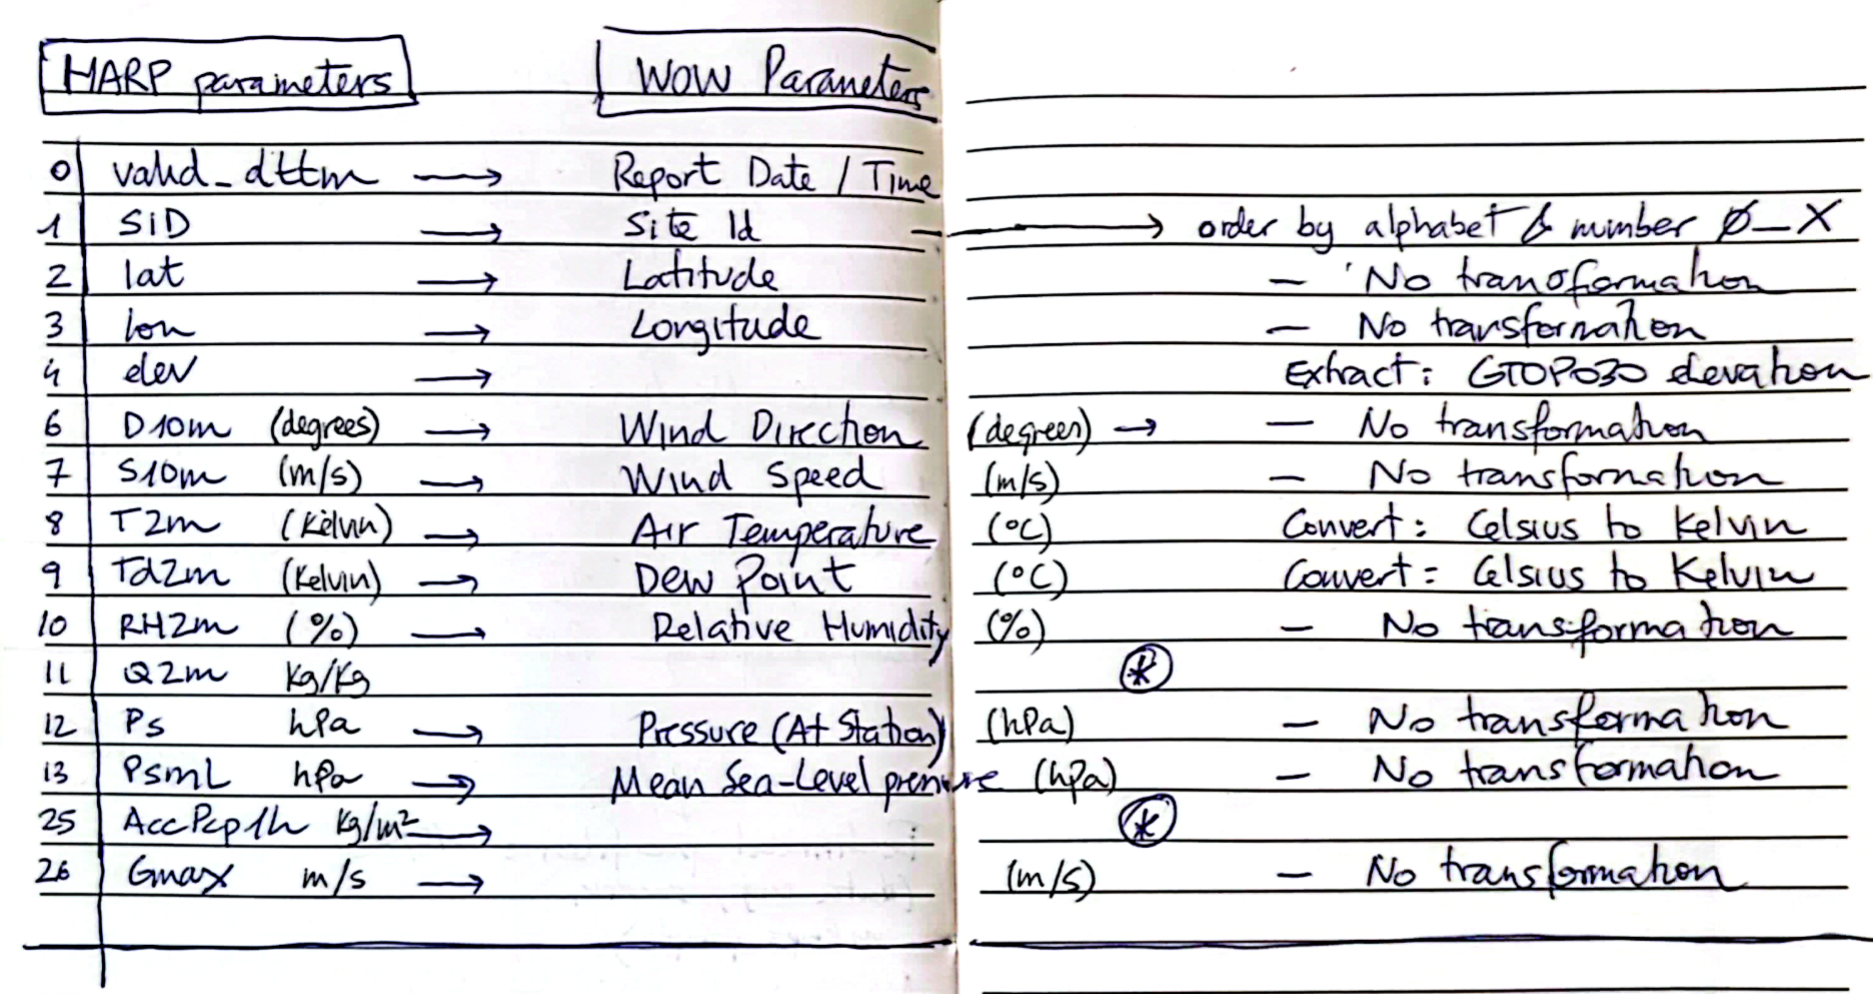
</div>

Transforming WOW datetimes in GMT to UTC looks like in this image below:

<div>
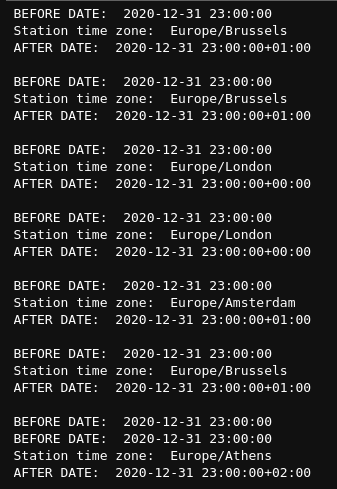
</div>



The next cell wrangles each of the hourly dataframes in `L2` so that they become the HARP format (with an additional column `Level` representing the quality control for air temperature

In [43]:
from collections import Counter 
from scipy.constants import convert_temperature
   

stations_not_found = 0
path_in_obs = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L2/WOW-Eumetnet-L2-2020-12-31_23.csv"
path_ou_harp = r"/home/jovyan/work/private/data-common/KNMI/eumetnet-wow-2020/proc/L3/WOW-Eumetnet-L3-2020-12-31_23.csv"

df_obs = pd.read_csv(path_in_obs, sep=";", header=0, index_col=None, parse_dates=[4])

# Column sanity: removing `WetBulb`, 'Id', 'geometry'
df_obs = df_obs.drop(columns=['Wet Bulb', 'Rainfall Rate', 'Wind Gust Direction', 'Id', 'geometry'])

# Column sanity: aggregate per hour, median for 'Level' column
l = []
groups = df_obs.groupby(['Site Id', pd.Grouper(key='Report Date / Time', freq='H')])
for idx, group in groups:
    counter = Counter(group["Level"].tolist()) 
    cur_level = counter.most_common()[0]
    cur_max_gust = group["Wind Gust"].max()
    group = group.drop(columns=['Level', 'Site Id', 'Report Date / Time', 'Wind Gust']).mean()
    
    # Putting the group back in place
    group['Report Date / Time'] = idx[1]
    # group['Site Id'] = idx[0]
    group['Wind Gust'] = cur_max_gust
    group['Level'] = cur_level[0]    

    # Adding elevation and substituting the long alphanumeric `Site Id` by the pre-computed
    # values (i.e. UTC Time Zone, HARP-integer-ID),found in the 2022 file: WOW_EUMETNET_CWS_Locations_2020_Within_Elevation.csv
    try:
        
        df_elev = dic["elev"]
        row_hit = df_elev[df_elev['Site Id'] == idx[0]]
        # group["SID"] = row_hit.index.values[0]
        group["SID"] = row_hit["HARP_SID_int"].values[0]
        group["elev"] = row_hit["elevation"].values[0]
        
        # Now the conversion GMT >>> UTC >>> Unix Time
        station_tz = row_hit["UTC_TimeZone"].values[0]
        timezone = pytz.timezone(station_tz)
        group["Report Date / Time"] = group["Report Date / Time"].tz_localize(timezone).timestamp()
        
        l.append(group.to_dict())
        
    except IndexError:
        # Back in 2022 I remember there were some ghost stations, so possibly these 
        # were not added to the CSV and now we have 'not found' stations
        stations_not_found += 1

print("Number of stations not found: ", stations_not_found)

# Piling together all the groups in a single dataframe
df = pd.DataFrame.from_dict(l)

print("\n")
print("\n")
print(df.head(5))
print(df.shape)

# Applying unit conversion operations
df["Air Temperature"] = df["Air Temperature"].apply(convert_temperature, args = ("Celsius", "Kelvin"))
df["Dew Point"] = df["Dew Point"].apply(convert_temperature, args = ("Celsius", "Kelvin"))


# Renaming and reordering columns
df = df.rename(columns={"Report Date / Time": "valid_dttm", "Latitude":"lat", "Longitude":"lon", 
                   "Wind Direction":"D10m", "Wind Speed":"S10m", "Air Temperature":"T2m", 
                   "Dew Point":"Td2m", "Relative Humidity":"RH2m", "Pressure (At Station)":"Ps",
                   "Mean Sea-Level Pressure":"Psml", "Rainfall Accumulation":"PcpAcc0UTC",
                   "Wind Gust":"Gmax"
                  })

harp_columns = ["valid_dttm", "SID", "lat", "lon", "elev", "D10m", "S10m", "T2m", "Td2m", "RH2m", "Ps", "Psml", "PcpAcc0UTC", "Gmax", "Level"]
df = df.reindex(columns=harp_columns)

df.to_csv(path_ou_harp, sep=";", header=True, index=False)

print("\n")
print("\n")
print(df.head(10))
print(df.shape)



Number of stations not found:  195




   Longitude   Latitude  Air Temperature  Dew Point  Mean Sea-Level Pressure  \
0   3.639800  51.103600         2.083333   1.870370                      NaN   
1   4.711000  50.876900         2.777778   2.015873                      NaN   
2  -0.127500  51.507200        42.333333  36.600000                      NaN   
3  -2.312967  52.137393        -2.083333  -2.777778              1010.329158   
4   7.039271  52.248325         2.171296   1.773148              1004.919402   

   Pressure (At Station)  Relative Humidity  Rainfall Accumulation  \
0             999.103279          99.000000                 0.0000   
1                    NaN          94.571429                 1.5240   
2            1009.901242          60.857143                 0.0000   
3                    NaN          95.000000                 0.2540   
4                    NaN          97.000000                 0.2794   

   Wind Speed  Wind Direction  Report Date / Time  Wind Gus